In [1]:
%load_ext autoreload
%autoreload 2
# Esto es útil si deseas modificar un módulo, estos cambios serán accesibles en el cuadernillo.


import numpy as np
import matplotlib
import sys
import matplotlib.cm as cm
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import astropy.io.fits as fits


%matplotlib inline
#%cd /Directorio/donde/estan/los/archivos

import constantes as cs # modulo de constantes
from cmb_modulos import * # modulo de funciones
N = cs.N
c_min = cs.c_min
c_max = cs.c_max
X_ancho = cs.X_ancho
Y_ancho = cs.Y_ancho
tamaño_pix = cs.tamaño_pix


# La estructura de este cuaderno

- Primero, revisaremos brevemente la necesidad y los tipos de métodos de separación de componentes.
- Luego, discutiremos un modelo simple para simular polvo y sincrotón y examinaremos su comportamiento espectral.
- A continuación, desarrollaremos un método de limpieza basado en una plantilla del primer plano.
- Finalmente, desarrollaremos un método simple de separación de componentes de tipo Internal Linear Combination (ILC) para aislar la polarización del modo CMB E y B en simulaciones simples.


# Una introducción rápida

Hasta ahora hemos considerado en gran medida las observaciones del cielo en una sola frecuencia. Desafortunadamente para nosotros como científicos del CMB, el cielo milimétrico está compuesto de muchas fuentes, tanto de origen galáctico como extragaláctico, que oscurecen las anisotropías del CMB. (Por supuesto, estas contribuciones son muy interesantes de estudiar como señales por si mismas, sin embargo, hoy limitaremos nuestra discusión a tratarlas como contaminantes).

Afortunadamente, estas otras señales, en adelante los primeros planos, tienen propiedades espectrales y espaciales diferentes a las anistropías CMB. Las propiedades espectrales de las señales galácticas clave se pueden ver en la Figura 1),

### Figura 1)

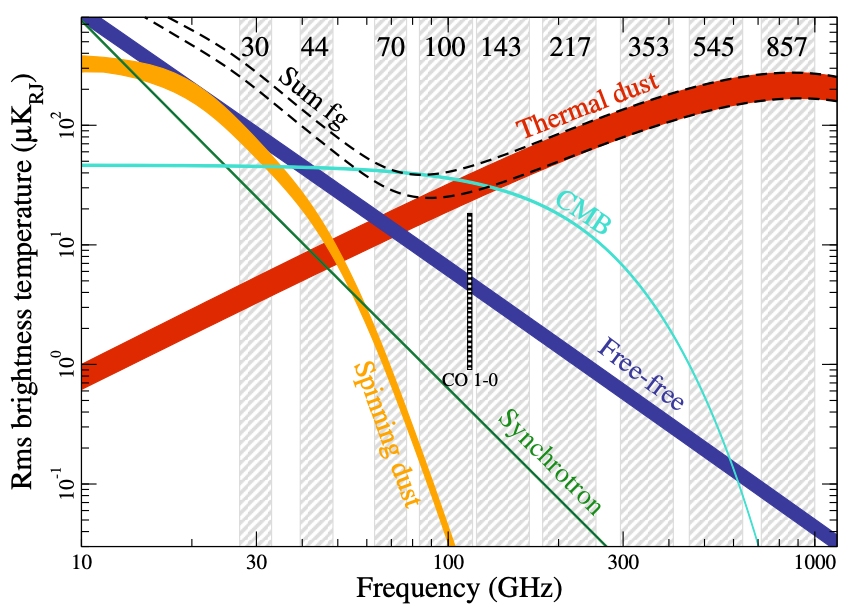

 Fuente: Dickinson et al (2016) - esta publicación da una buena descripción general de las contribuciones galácticas al cielo milimétrico (arXiv:1606.03606)
 
Vemos que incluso si observamos el cielo alrededor de 70 GHz de temperatura, donde el CMB es la señal dominante del cielo, las señales galácticas no son despreciables (y tampoco lo son las fuentes extragalácticas). Por lo tanto, para cualquier análisis de las anisotropías de CMB, debemos comprender y/o eliminar estas señales.

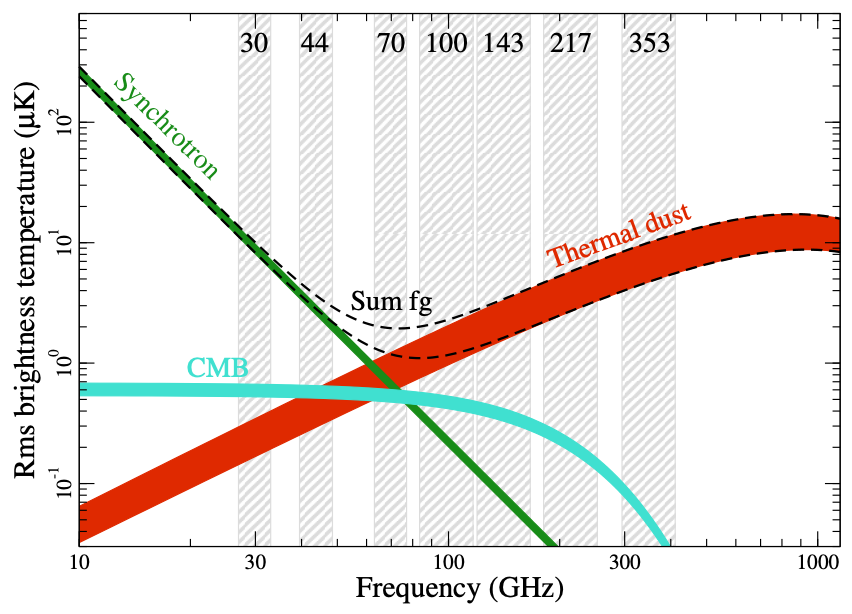

Las técnicas de mitigación de primer plano se pueden agrupar ampliamente en dos clases que llamaremos métodos no-ciegos y ciegos. En los métodos no-ciegos, generalmente asumimos una forma paramétrica para las propiedades espectrales y potencialmente espaciales de los primeros planos. Dado este modelo y una probabilidad (casi siempre una probabilidad gaussiana) se ajusta a las propiedades del modelo de primer plano y el CMB. Luego, podemos usar un método de máxima verosimilitud o un método basado en muestreo (ver por ejemplo cuadernillos de MCMC) para recuperar el CMB. Este enfoque se ha utilizado ampliamente en la comunidad CMB para marginar las contribuciones de los primeros planos extragalácticos a pequeña escala. Por lo tanto, cuando ves gráficos de los espectros de potencia de temperatura CMB, por ejemplo, la Figura 2, es probable que esté viendo los resultados de un método de separación de componentes no-ciego/paramétrico:


### Figure a)

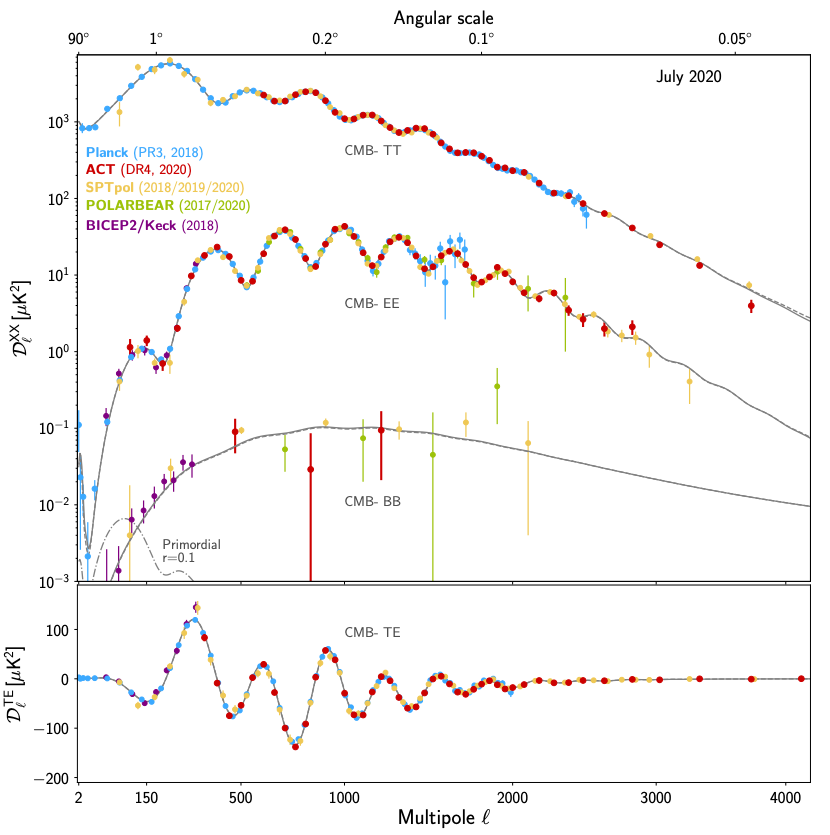

Fuente: Choi et al 2020 (arXiv:2007.07289)

Los métodos ciegos suponen que se conoce perfectamente la dependencia espectral de la señal primaria. Luego hacen suposiciones mínimas sobre las propiedades de los primeros planos para obtener el componente CMB. En este tutorial exploraremos uno de los métodos más simples: la combinación lineal interna (Internal Linear Combination o ILC). Solo asume que los primeros planos no están correlacionados con las anisotropías CMB. Este método entonces combina linealmente las observaciones para obtener un mapa CMB que minimiza la varianza de este componente. 
Para obtener esta solución, las propiedades de los primeros planos se estiman implícitamente a partir de los datos empíricos. Discutiremos los detalles de esto más abajo.

Como siempre, cada método de separación de primer plano tiene sus ventajas y desventajas y debe elegirse para adaptarse al problema específico.


# ¿Cómo puedo hacer una simulación rápida de los primeros planos galácticos?

Hay buenos códigos de simulación disponibles, incluido PySM, como se indica a continuación. Pero por ahora supongamos algo más simple y parcialmente realista. Asumiremos que solo hay dos componentes: sincrotrón y polvo con aproximadamente la dependencia de frecuencia correcta y dependencia angular semirrealista. Los generamos con realizaciones gaussianas para tener un espectro que escala como Dl~l^0.7, pero luego agregamos un comportamiento galáctico no gaussiano tomando el valor absoluto de este campo y agregando un gradiente (por ejemplo, para imitar la reducción de la señal lejos del plano galáctico). El escalado como ley de potencia de la intensidad en unidades RJ es la frecuencia a la potencia de -3 para sincrotrón y 1.7 para el polvo (aunque el polvo se modela mejor no como una ley de potencia pero como un cuerpo negro modificado), esto significa que a frecuencias más altas, por ejemplo pasando de 150 a 220 GHz la intensidad del sincrotrón decae, y por el contrario el polvo se hace más fuerte.

Notar que también hay otros primeros planos en intensidad, incluida la emisión de microondas anómala (Microwave Anomalous Emission), libre (free-free) y la emisión de la línea de CO, que estamos ignorando aquí por razones pedagógicas pero deberían considerarse en simulaciones completas

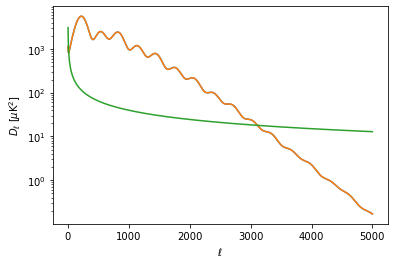

In [83]:
# leer en los espectros CMB de entrada
ell, DlTT = np.loadtxt("CAMB_fiducial_cosmo_scalCls.dat", usecols=(0, 1), unpack=True)
plt.plot(ell,DlTT)

#Aproximar un espectro de potencia de primer plano en alguna frecuencia de referencia
Dl_pp = 0.5e4*ell**-.7 
plt.plot(ell,DlTT)
plt.semilogy(ell,Dl_pp)
plt.ylabel('$D_{\ell}$ [$\mu$K$^2$]')
plt.xlabel('$\ell$')
plt.show()

promedio del mapa: 20.02109463083551 , media cuadrática (rms) del mapa: 100.47168680399936


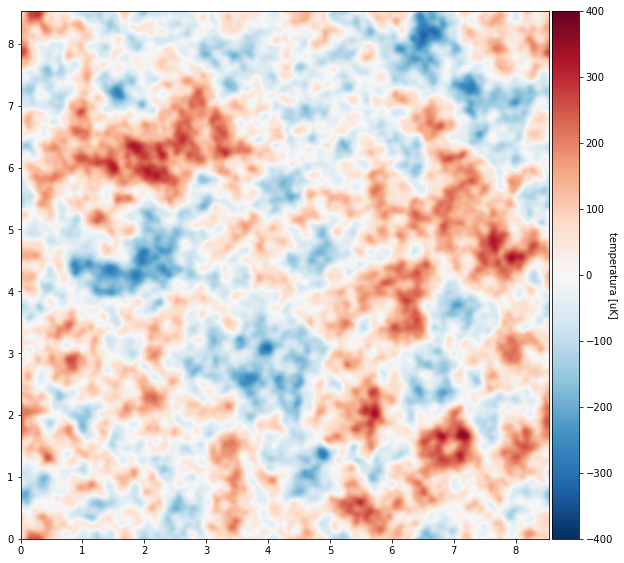

promedio del mapa: 48.69716363543663 , media cuadrática (rms) del mapa: 21.969650537642167


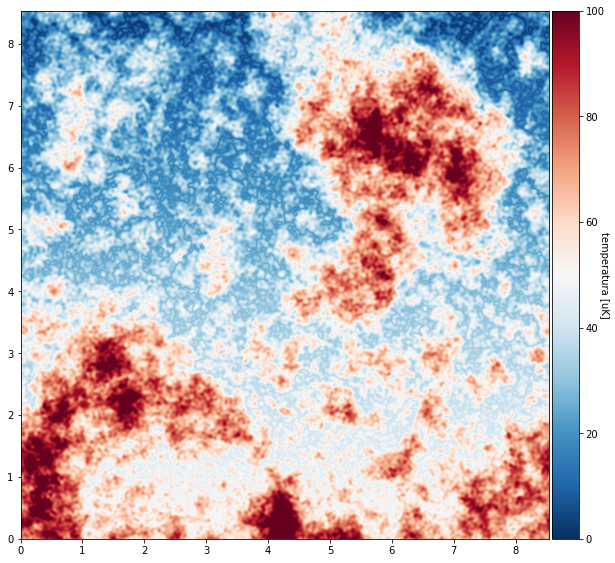

0

In [84]:
# hacer un sistema de coordenadas de espacio real 2D
onesvec = np.ones(N)
inds  = (np.arange(N)+.5 - N/2.) /(N-1.) # crear un arreglo de tamaño N entre -0.5 y +0.5
# calcular la matriz del producto exterior: X[i, j] = onesvec[i] * inds[j] for i,j
# en el rango (N), que es solo N filas de copias de inds - para la dimensión x
X = np.outer(onesvec,inds) 
# calcular la transpuesta para la dimensión y
Y = np.transpose(X)

CMB_T = crear_mapa_CMB_T(N,tamaño_pix,ell,DlTT)
pp1 = crear_mapa_CMB_T(N,tamaño_pix,ell,Dl_pp)
pp1 = np.abs(pp1)+((0.5-Y)*50)   #polvo - con un termino gradiente arbitrario

pp2 = crear_mapa_CMB_T(N,tamaño_pix,ell,Dl_pp)
pp2 = np.abs(pp2)+((0.5-Y)*50)   #sinc - con un termino gradiente arbitrario

Graficar_Mapa_CMB(CMB_T,c_min,c_max,X_ancho,Y_ancho)

Graficar_Mapa_CMB(pp2,0,100,X_ancho,Y_ancho)


Ahora, averigüemos cómo los mapas de componentes deben escalar con la frecuencia, calculando la escala esperada de intensidad en comparación con una frecuencia de referencia de 90 GHz en unidades de temperatura CMB. Podemos hacer esto tanto en unidades de temperatura CMB (donde un cuerpo negro tiene una frecuencia plana), como también en unidades RJ. El comportamiento de la ley de potencias está en unidades RJ.


In [85]:
# escalado por frecuencia

exponente_polvo= 1.7
exponente_sinc = -3.
frecuencia_ref = 90.  # en GHz

T_CMB = 2.72548
h = 6.62607015e-34
k = 1.380649e-23 
H_SOBRE_KT_CMB = h * 1e9 / k / T_CMB # h/(kT)

bandas = np.array([27.,37.,90.,145.,225.,280.])  ## en GHz

def escalamiento_polvo(frec,exponente_polvo,frecuencia_ref):
    escalamiento_polvo = (frec / frecuencia_ref)** exponente_polvo
    return(escalamiento_polvo)

def escalamiento_sinc(frec,exponente_sinc,frecuencia_ref):
    escalamiento_sinc = (frec / frecuencia_ref)** exponente_sinc
    return(escalamiento_sinc)

def rjacmb(nu):
    x = H_SOBRE_KT_CMB * nu
    return (np.expm1(x) / x)**2 / np.exp(x)

np.set_printoptions(precision=3,suppress=True)

print("bandas: ", bandas)
print("escalado polvo (RJ): ",  escalamiento_polvo(bandas,exponente_polvo,frecuencia_ref))
print("escalado sinc (RJ):  ",  escalamiento_sinc(bandas,exponente_sinc,frecuencia_ref))
print("escalado polvo (T_CMB): ", escalamiento_polvo(bandas,exponente_polvo,frecuencia_ref)*rjacmb(bandas))
print("escalado sinc (T_CMB):  ", escalamiento_sinc(bandas,exponente_sinc,frecuencia_ref)*rjacmb(bandas))

bandas:  [ 27.  37.  90. 145. 225. 280.]
escalado polvo (RJ):  [0.129 0.221 1.    2.25  4.748 6.886]
escalado sinc (RJ):   [37.037 14.392  1.     0.239  0.064  0.033]
escalado polvo (T_CMB):  [ 0.132  0.229  1.228  3.771 15.299 38.651]
escalado sinc (T_CMB):   [37.74  14.908  1.228  0.401  0.206  0.186]


A continuación, mostramos un código que grafica el mapa CMB junto con los primeros planos galácticos para la banda de 90 GHz

map mean: 134.80325680231275 map rms: 112.43522443781983


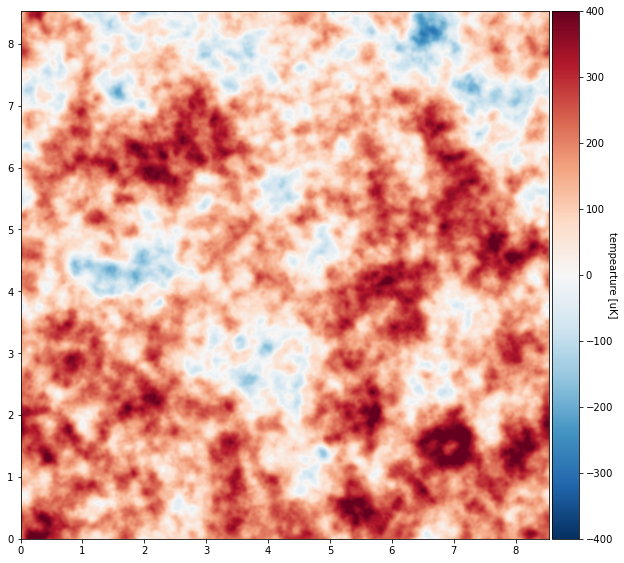

0

In [86]:
banda = 90.
polvo_escalado = escalamiento_polvo(banda,exponente_polvo,frecuencia_ref)*rjacmb(banda)
sinc_escalado = escalamiento_sinc(banda,exponente_sinc,frecuencia_ref)*rjacmb(banda)

Mapa_90GHz = CMB_T + pp1*polvo_escalado +pp2*sinc_escalado

Plot_CMB_Map(Mapa_90GHz,c_min,c_max,X_ancho,Y_ancho)

## Ejercicio 1.

Realice gráficos del cielo (CMB + primeros planos) en diferentes bandas. Tenga en cuenta cualitativamente cómo cambia el nivel de primer plano con la frecuencia.

In [87]:
#Tu código y gráficos van aquí.




Ahora veamos la señal en los mapas en función de la frecuencia. Podemos calcular el rms para uno de los mapas como

In [88]:
rms90 = np.sqrt(np.mean(Mapa_90GHz**2))
print('rms 90 GHz = ', rms90, 'uK')

rms 90 GHz =  175.5380236270569 uK


## Ejercicio 2

Ahora calcula esto para las otras frecuencias y compara la escala de la señal total en comparación con el CMB. (es decir, graficar el valor del rms versus frecuencia)

In [89]:
#Tu código va aquí

In [90]:

# 220
banda = 220.
polvo_escalado = escalamiento_polvo(banda,exponente_polvo,frecuencia_ref)*rjacmb(banda)
sinc_escalado = escalamiento_sinc(banda,exponente_sinc,frecuencia_ref)*rjacmb(banda)
Mapa_220GHz = CMB_T + pp1*polvo_escalado +pp2*sinc_escalado

# 280
banda = 280.
polvo_escalado = escalamiento_polvo(banda,exponente_polvo,frecuencia_ref)*rjacmb(banda)
sinc_escalado = escalamiento_sinc(banda,exponente_sinc,frecuencia_ref)*rjacmb(banda)
Mapa_280GHz = CMB_T + pp1*polvo_escalado +pp2*sinc_escalado


map mean: 659.9132111182932 map rms: 320.05446041851735


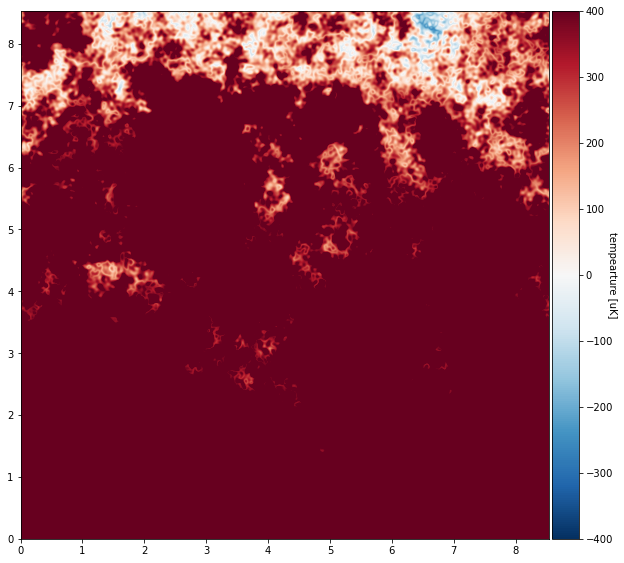

0

In [91]:
Plot_CMB_Map(Mapa_220GHz,c_min,c_max,X_ancho,Y_ancho)

map mean: 1760.7277406035664 map rms: 823.0413379155825


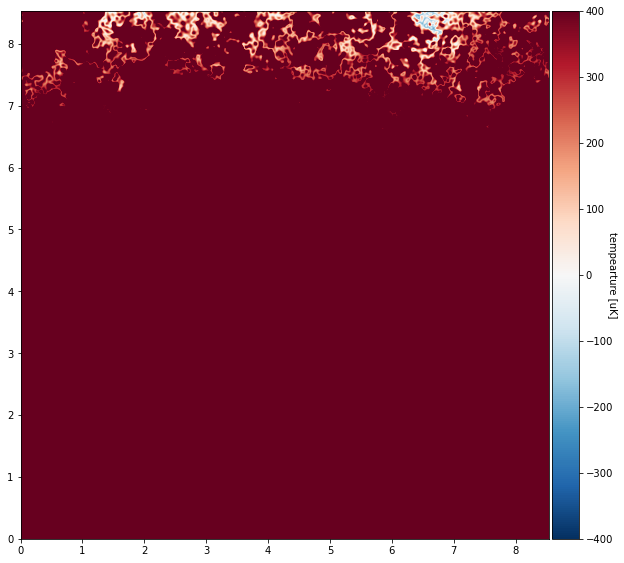

0

In [92]:
Plot_CMB_Map(Mapa_280GHz,c_min,c_max,X_ancho,Y_ancho)

Notar que la intensidad de los primeros planos en realidad no es tan grandes en la parte del cielo que generalmente usamos para análisis de CMB. En estas zonas a una frecuencia de 90-150 GHz el CMB domina en intensidad. Este es solo un ejemplo extremo para que podamos ver más fácilmente los efectos de la limpieza de los primeros planos.

## Sustracción de plantilla

Ahora podemos probar un método muy simple para limpiar un mapa: definamos una plantilla que trace el primer plano y elimine una versión escalada de la plantilla del mapa. Encuentre el coeficiente de plantilla, es decir, cuánto debe escalarse, minimizando la variación en el mapa limpio. Aquí descuidaremos el sincrotrón e intentaremos quitar el polvo de 150 GHz. Haremos una plantilla a partir de la diferencia de 280-220GHz, ya que entonces el CMB común a ambos se cancelará.

In [93]:
## create a dust template

plantilla_polvo =  (Mapa_280GHz-Mapa_220GHz)



## Ejercicio 3

Encuentre los coeficientes de la plantilla que minimizan la varianza en el mapa (¡esto se puede hacer de forma cruda ~ al ojo o de manera más sofisticada, como prefiera!). Graficar el cielo completo observado, el cielo limpiado, el CMB de entrada


In [94]:
#

# El método de Combinación Lineal Interna (Internal Linear Combination/ILC)

Aplicaremos el método ILC en el espacio armónico para generar mapas de modos E y B; sin embargo, este método se puede aplicar de cualquier manera (por ejemplo, en el espacio real o en los Cl mismos), por lo que en nuestra discusión a continuación usamos una notación general.

Tenemos un conjunto de observaciones del cielo, $\hat{d}_{\nu_i}(\mathbf{n})$, en frecuencia, $\nu_i$, e índice espacial/armónico $\mathbf{n}$ .

Estamos interesados en recuperar la señal, $s(\mathbf{n})$ , que contribuye a una observación en cada frecuencia multiplicada por $a_{\nu_i}s(\mathbf{n})$. Para este método asumimos que conocemos exactamente la función espectral y por lo tanto podemos calcular $a_{\nu_i}$. ¡Para el CMB, sabemos esto con mucha precisión!

Dado este modelo de señal, podemos expresar nuestro vector de datos como:

### $\hat{d}_{\nu_i}(\mathbf{n}) = a_{\nu_i}s(\mathbf{n}) + n_{\nu_i}$

donde $ n_{\nu_i}$ se denomina 'ruido' a la frecuencia $\nu_i$. ¡Este 'ruido' en realidad se compone de todo lo que no es la señal de interés! En nuestro caso el ruido estará compuesto por el ruido experimental, la emisión de polvo y la emisión de sincrotrón.

La idea del ILC es crear una combinación lineal de estos mapas para recuperar la señal:

### $\hat{s}(\mathbf{n}) = \sum\limits_i w_i(\mathbf{n})\hat{d}_{\nu_i}(\mathbf{n})$.

(Para mayor claridad suprimimos el índice \mathbf{n} de aquí en adelante)

Imponemos dos condiciones a estos pesos:
- En primer lugar, queremos una medición imparcial de la señal. Por lo que imponemos:

### $\sum\limits_i w_i a_{\nu_i} = 1$.
- En segundo lugar, queremos el nivel de ruido más bajo posible en el mapa resultante. Es decir.:

### $\frac{\partial}{\partial w_i} \langle \hat{s}(\mathbf{n}) \hat{s}(\mathbf{n}) \rangle =0 $

Es un ejercicio sencillo demostrar que los pesos que satisfacen estas condiciones están dados por

### $w_i =\frac{{C^{-1}}^{\nu_i,\nu_j} a_{\nu_j}}{a_{\nu_i}{C^{-1}}^{\nu_i,\nu_j} a_{\nu_j}}$

donde ${C^{-1}}^{\nu_i,\nu_j}$ es la matriz de covarianza canal a canal

Por lo tanto, la solución para el mapa CMB es

### $\hat{s}(\mathbf{n}) = \frac{a_{\nu_i}{C^{-1}}^{\nu_i,\nu_j}\hat{d}_{\nu_j} }{a_{\nu_i}{C^{-1}}^{\nu_i,\nu_j} a_{\nu_j}} $

A priori no siempre (o incluso a menudo) conocemos la matriz de covarianza frecuencia-frecuencia. ¡Para resolver esto usamos la matriz de covarianza empírica!

En algunos casos, queremos tener un mapa que anule explícitamente un componente en el cielo. El método ILC se puede ampliar para hacer esto. Ver: https://arxiv.org/pdf/1911.05717.pdf

Limitaciones del método ILC:

- Si se tiene una forma paramétrica precisa para todos los componentes del cielo, es probable que este modelo logre una reconstrucción de menor ruido.
- Suponemos que el componente de interés tiene una forma espectral única. Si tiene un segundo componente con la misma respuesta de frecuencia, esto también estará presente en tu mapa final. Como un ejemplo práctico: un mapa ILC de las anisotropías de temperatura primarias contendría tanto las anisotropías CMB como la señal kSZ.
- Como el ruido restante es una combinación de ruido instrumental y primeros planos residuales, es difícil construir divisiones de los datos con ruido independiente. Por lo tanto, los espectros de potencia de los mapas siempre tendrán un término de sesgo de ruido que debe calcularse (a menudo mediante simulaciones).
- Se debe tener precaución si parte del 'ruido' se correlaciona con la señal de interés

# ¡Vamos a probarlo!

Generemos un conjunto de observaciones idealizadas.

In [10]:
# For simplicity we made a simple python object that can be used to easily generate observations.
import foregrounds
simple_sky_model = foregrounds.simple_sky_model(seed=1)

ImportError: cannot import name 'sharp' from 'pixell' (/Users/cvargas/.local/lib/python3.9/site-packages/pixell-0.15.3+24.g662ae68.dirty-py3.9-macosx-11.0-arm64.egg/pixell/__init__.py)

### Lets generate some mock observations

In [ ]:
maps = {}
for freq in [30,90,120,150,220]:
    T_map      = simple_sky_model.observe(freq_GHz=freq,noise_ukarcmin=3.,beam_fwhm_arcmin=freq/150.*20.)
    maps[freq] = T_map

In [ ]:
# View the maps:

In [ ]:
# eshow(maps[220],downgrade=4)
# eshow(maps[30],downgrade=4)

## Note that these maps are now full sky maps in CAR pixellation

We can use the tools in the pixell library to analyze these maps! 

First lets import pixell

In [ ]:

from pixell import enmap,curvedsky,enplot,utils
import foregrounds
def eshow(x,**kwargs): 
    ''' Define a function to help us plot the maps neatly '''
    plots = enplot.get_plots(x, **kwargs)
    enplot.show(plots, method = "ipython")


## The following functions will be of use:

This function performs the spherical harmonic transform to the desired lmax
### curvedsky.map2alm( Your_map_as_an_enmap, lmax=desired_lmax)

This function performs the inverse spherical harmonic transform. The second input should be an enamp. The output will be written here. (This contains the geometry (sky area, pixel size etc) of your map!)
### curvedsky.alm2map( Your_Alms, an_enmap_map_to_contain_the_output)

This function can be used to multiply the alms by a fuction of ell (all ms at each ell are times by the same value). The second argument is either an array of the function values at ell=0,1 ... ell_max or a function f(\ell)
### curvedsky.almxflx(Your_Alms, array or function to apply to alms)

This function computes the Cls from the alms
### curvedsky.alm2cl(alm_0,alm_1) # Note alm_1 is only needed for cross correlations.

## Step 1)
Measure the alms and the auto and cross spectra

In [ ]:
### Your code here



# Step 2)

Construct the ILC! Compute at each $\ell$:
### $w_i =\frac{{C^{-1}}^{\nu_i,\nu_j} a_{\nu_j}}{a_{\nu_i}{C^{-1}}^{\nu_i,\nu_j} a_{\nu_j}}$

Compute the weights separately for the E/B modes.
(Typically np.linalg.solve gives more stable inv. C applications than directly computing the covariance matrix.)

Use curvedsky.almxfl to apply the weights to the alms.

In [ ]:
### Your code here



# Step 3)

Compare to the ground truth (perhaps easiest to do at the power spectrum level).

In [ ]:
# alm_cmb_T = simple_sky_model.get_input_cmb_alms()

### Your code here


# Step 4)

Compute the cross power spectrum of the ILC map with the input dust and sync maps (use the two functions below for retrieving those!). Is this consistent with zero?



In [ ]:
# # These function can be used to get the sky dust and sync components

# alm_dust_T= simple_sky_model.get_input_dust_alms()

# alm_sync_T= simple_sky_model.get_input_sync_alms()

# Step 5)

Put your code in a loop. Generate a set of new maps (change the seed for the sky each time) and a new set of ILC maps. Does your method give an unbiased measurement of the sky?

In [ ]:

### Your code here

# Optional extension 1)
Did you find a bias? This is known as the ILC bias! 


This bias occurs due to our use of the empirical covariance matrix in the weights. This can be understood simply: the weights depend on the data, imagine we have a large upward fluctuation in the data, this will result in a large fluctation in the covariance and will result in that mode being excessively downweighted in the ILC solution (the covariance matrix depends on the data squared). Phrased more broadedly the covariance matrix has correlation with the data and so when we compute the expected value for the ILC solution we need to include these.


For a comprehensive discussion of this see the appendicies of https://arxiv.org/pdf/0807.0773.pdf

#### How can we avoid this?  
- The true covariance matrix! Unfortunately this is not generally available.
- Compute the covariance matrix from an independent set of modes.
- In our case we can make the approximatation the covariance of adjacent $\ell$ is same. Thus we can compute the covariance matrix at each ell using the spectra at $\ell+1$ and  $\ell-1$. 
- This approach can be difficult to implement in practice where different ells are correlated (e.g. do to masking) and as it rapidly becomes computationally very expensive.

#### How can we supress this? 
- We can use reduce these biases by averaging modes. 
- For our case we can do this simply. Instead of using the measured power spectrum at each ell $C_\ell$, we can average over a range of ells. This will reduced the correlation between the covariance matrix and the data.

## Try one of the above approaches. Does it supress the bias?

# Optional extension 2)

We can now try out this method on the polarized sky. This will require using the E/B methods we explored yesterday.

Lets first explore the sky in polarization.

### Task 1)

Observe the sky and create an empirical version Figure 1) for E and B mode polarization. 

I.E. Observed rms E /B mode vs frequency (or if you prefer C(ell=50) and C(ell=300) EE, BB vs freq).

In [ ]:
# To generate a sky use this class. The interface is the same, however the function returns two maps: Q and U.
simple_sky_model = foregrounds.simple_sky_model_pol(seed=1)
Q_map,U_map      = simple_sky_model.observe(freq_GHz=freq,noise_ukarcmin=3.,beam_fwhm_arcmin=freq/150.*20.)

In [ ]:
### Your code goes here

We actually know that the polarized sky is slightly simpler than the temperature case. At the frequenies of interest there are just three non-negligible components: dust, synchrotron and the CMB.

Lets make a quick estimate of the relevance of each of the components. 

For this part we can also increase the realism of the component frequency spectra:

The synchroton spectral energy distribution is modelled as a power law in frequency, as before.

The dust SED is modelled as a grey body:
$I(\nu) = \nu^\beta B_\nu(T_d)$ where $\beta$ is the dust  spectral index that is observed to be $\sim 1.4$ and T$_d$ is the dust temperature that is $\sim 15$K.

One slight complication. The dust SED are measures of flux and so are in Janksys per steradian whereas we normally think in terms of temperature units for the CMB anisotropies (frequently $\delta T/T$ or $\mu$K or nK). To plot the three components you should standardize the units. (If you need some ideas on how to do this perhaps have a look around eq.5 and eq.6 here: https://arxiv.org/pdf/1303.5087.pdf)

In [ ]:
from foregrounds import synchrotron_SED,galaticDust_SED
# Example usage
print(synchrotron_SED(freq_GHz=30))
print(galaticDust_SED(freq_GHz=150))

### Step 2)

Now we lets reapply the ILC to these maps.

First observe the sky at a range of frequencies.

Second convert from Q/U to E/B

Third measure the auto and cross power spectra (are there any E cross B power spectra? )

Next compute the ILC weights (it is best done separately for E/B)

Finally apply your weights and compare the maps and power spectra!

# Optional extension 3)

The model of the galaxy used here is overly simplistic! 

Lets repeat this exercise with a more accurate model. We can use the excelent pysm library for this purpose. 

The installation instructions for this library are available here: https://pysm3.readthedocs.io/en/latest/#installation

However, one of these commands should work for you too:

pip install pysm3

conda install -c conda-forge pysm3


The library can be straightforwardly used with a few lines of code:




In [ ]:
# Import the library and the units module for convienience:
import pysm3;
import pysm3.units as u

With the library imported we initalized the sky class.
- nside sets the resolution of the maps, 
- preset_strings defines the models used for the sky. In this case we the models 'd1' for dust 1 and "s1" for synchroton model one. More information on the available models can be found on : https://pysm3.readthedocs.io/en/latest/  . The more accurate models allow use to test how well our foreground cleaning methods work when, for example, the dust spectral index varries across the map


Note when using this for the first time it will require an internet connection as it will download a set of template maps. This will generate a set of warnings.

In [ ]:
# Initalize the sky object

sky = pysm3.Sky(nside=512,preset_strings=["d1","s1"],output_unit="K_CMB")
# Get the map at the desired frequency:
I,Q,U = sky.get_emission(150*u.GHz)

In [ ]:
hp.mollview(Q)
hp.mollview(U)

For ease we have included a simple wrapper of this in a format identical to our simple model

In [ ]:
pysm_sky_model = foregrounds.pysm_sky_model(seed=1)
pysm_sky_model.observe(freq_GHz=150,noise_ukarcmin=1.,beam_fwhm_arcmin=8.)

## Apply the ILC to these more realistic maps

Can you obtain lower noise E/B maps through masking? 

You can download the planck galaxy mask with this link:

http://pla.esac.esa.int/pla/aio/product-action?MAP.MAP_ID=HFI_Mask_GalPlane-apo2_2048_R2.00.fits


We can read the sky mask using the following command:
### hp.read_map(fileNameHere,field=index)

index is used to select the desired sky fraction as follows:

0: 20%, 1: 40%, 2: 60%, 3: 70%, 4: 80%, 5: 90%, 6: 97%, 7: 99%

# Optional extension 4)

 As discussed above the ILC method can be altered to 'deproject' sky components such that the ILC map not only minimizes the variance on the desired signal but also has zero contribution from a specific component. This is useful if, for example, you want to be sure your CMB map has not contribution from the SZ effect. The cost of this is an increase in the variance in the ILC map.
 
 
This method requires that we accurately know the signal of interests frequency function. Unfortunately this means that it can be used only to reduce residual dust and CIB contributions - not completely remove them! 

## Step 1)

First we need to modify the ILC equation. Recall that to derive the ILC equation we sought a solution that has unit response to the desired signal with minimum variance. To obtain the weights we minize the variance in the presences of a Lagrange multiplier to ensure unit reponse. Now we can simply add an additional constraint. 

First deduce the constraint and then recompute the ILC weights. 

You should find that your solution agrees with eq. 18 in https://arxiv.org/pdf/1006.5599.pdf

# Step 2)

Rerun your code from above using the modified weights. Deproject the dust contribution using the spectral functions from the first section.